# Machine Type Trends at Bases (FY2020–FY2024)

> **How have the types of games or machines installed at bases changed over time?**

It uses the combined asset details file for FY2020–FY2024 and produces:
- Overall trends in machine types over time
- Base-level trends in machine types over time

Machine types are grouped into four main categories:
- `SLOT` – gaming machines (slots, video poker, keno, multi-game, etc.)
- `FRS` – financial/register systems (POS, registers, SUREPOS, etc.)
- `ITC` – IT/communications equipment (servers, PCs, network gear, etc.)
- `ACM` – automated cash machines (ATMs, ACMs, cash dispensers)

Anything not matching known patterns was initially labeled OTHER, but classification refinement reduced this group significantly.

This notebook explores how the mix and volume of gaming machines installed at bases changes from fiscal year 2021 through 2024, using the Asset Report Final tables.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Display options
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 40)
pd.set_option('display.width', 120)

## Load asset details for FY2020–FY2024

We loop over years, look for an asset_details_YYYY.csv in each year's FYYYYY Asset Report Final folder, and concatenate whatever we find into a single assets DataFrame.

In [3]:
import os
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # <-- you use sns later, so import it here

# --- Configuration ---
# Use raw string or forward slashes for paths to avoid Windows escape character errors
BASE_DIR = Path(r"fa25-team-b/CSVs")
YEARS = [2020, 2021, 2022, 2023, 2024]

dfs = []

for year in YEARS:
    # Handle potential inconsistent naming (some years might lack 'Final' or have different spacing)
    # This tries to find the folder specifically for that year
    year_folder = list(BASE_DIR.glob(f"*FY{year}*"))
    
    if year_folder:
        csv_path = year_folder[0] / f"asset_details_FY{year}.csv"
        
        if csv_path.exists():
            print(f"Loading: {csv_path.name}")
            df = pd.read_csv(csv_path)
            df["Year"] = year
            
            # Standardize Base Name immediately (Use FOSHORT, fallback to LNAME)
            if "FOSHORT" in df.columns:
                df["Base"] = df["FOSHORT"]
            elif "LNAME" in df.columns:
                df["Base"] = df["LNAME"]
            else:
                df["Base"] = "Unknown"
                
            dfs.append(df)
        else:
            print(f"Warning: File not found {csv_path}")
    else:
        print(f"Warning: Folder for FY{year} not found")

# --- New: guard against empty dfs so you don't get "No objects to concatenate" ---
if not dfs:
    raise FileNotFoundError(
        f"No asset_details_FY<year>.csv files were found under {BASE_DIR}. "
        "Check that BASE_DIR is correct and that the FYxxxx folders exist."
    )

assets = pd.concat(dfs, ignore_index=True)

# Clean up string columns
if "Desc" not in assets.columns:
    raise KeyError(
        "Column 'Desc' not found in assets. "
        "Make sure the CSVs have a 'Desc' column (or rename it before this cell)."
    )

assets["Desc"] = assets["Desc"].astype(str).str.upper().str.strip()
assets["Vendor"] = assets["Desc"].apply(lambda x: x.split()[0] if len(x) > 0 else "UNKNOWN")

print(f"Total records loaded: {len(assets)}")


Loading: asset_details_FY2020.csv
Loading: asset_details_FY2021.csv
Loading: asset_details_FY2022.csv
Loading: asset_details_FY2023.csv
Loading: asset_details_FY2024.csv
Total records loaded: 19918


## Machine Type Classification Logic

Machine assets are categorized into four functional groups based on keyword matching within their description fields.
The classification rules use a hierarchy of overrides, supplemental keyword sets, and primary keyword lists.

Groups

SLOT — Gaming machines (slot, video poker, keno, multi-game, etc.)

FRS — Financial/register systems (POS, SurePOS, registers, cashiering systems)

ITC — IT and communications hardware (servers, PCs, printers, networking gear)

ACM — Automated cash machines (ACMs, ATMs, cash dispensers)

OTHER — Anything not matched by the rule set

In [4]:
# --- Classify machine types into SLOT / FRS / ITC / ACM ---
import pandas as pd

SLOT_KEYWORDS = [
    'GAME KING', 'MULTI GAME', 'MULTI-GAME', 'MULTI SLOT', 'SLOT',
    'VIDEO SLOT', 'VIDEO', 'VLT', 'KENO', 'POKER', 'REEL', 'STEP',
    'STEPPER', 'PROGRESSIVE',
    # vendor names typically used for gaming
    'IGT', 'BALLY', 'ARUZE', 'ARISTOCRAT', 'KONAMI', 'EVERI', 'NOVOMATIC'
]

ACM_KEYWORDS = [
    'ACM', 'ATM', 'AUTOMATED CASH', 'CASH MACHINE',
    'CASH DISPENSER', 'AUTOMATED TELLER'
]

FRS_KEYWORDS = [
    'SUREPOS', 'POS', 'POINT OF SALE', 'CASH REGISTER',
    'REGISTER', 'REDEMPTION KIOSK', 'TITO', 'MONEY HANDLER',
    'CASHIERING'
]

ITC_KEYWORDS = [
    'SERVER', 'PC', 'DESKTOP', 'LAPTOP', 'NOTEBOOK', 'WORKSTATION',
    'PRINTER', 'ROUTER', 'SWITCH', 'MODEM', 'ACCESS POINT',
    'FIREWALL', 'UPS', 'NETWORK', 'HUB', 'TERMINAL'
]

MANUAL_OVERRIDES = {
    'IBM SUREPOS': 'FRS',   # IBM SUREPOS 4852 etc.
    'DIEBOLD ACM': 'ACM',   # Diebold automated cash machines
}

SLOT_EXTRA = [
    "M3T", "NOV", "NOVOSTAR", "PREM", "WMS", "BLADE",
    "BAL ", "BALLY", "JIN-JI", "BAO", "MLP", "SLANT"
]

ACM_EXTRA = [
    "SMART CARD DISPENSER", "CARD DISPENSER"
]

def classify_group4(desc: str) -> str:
    if pd.isna(desc):
        return "OTHER"
    text = desc.upper()

    # Manual overrides
    if text.startswith("IBM SUREPOS"):
        return "FRS"
    if "DIEBOLD" in text and "ACM" in text:
        return "ACM"

    # High-confidence new rules
    if any(x in text for x in ACM_EXTRA):
        return "ACM"

    if any(x in text for x in SLOT_EXTRA):
        return "SLOT"

    # Original rules
    if any(k in text for k in ACM_KEYWORDS):
        return "ACM"
    if any(k in text for k in SLOT_KEYWORDS):
        return "SLOT"
    if any(k in text for k in FRS_KEYWORDS):
        return "FRS"
    if any(k in text for k in ITC_KEYWORDS):
        return "ITC"

    return "OTHER"


# Apply classification
assets['Group4'] = assets['Desc'].apply(classify_group4)
print(assets['Group4'].value_counts())
assets[['Asset', 'Base', 'Year', 'Desc', 'Group4']].head(10)


Group4
SLOT     13440
ACM       2548
OTHER     2072
FRS       1858
Name: count, dtype: int64


,Asset,Base,Year,Desc,Group4
0,130582,KAISERSLAUTERN,2020,IBM SUREPOS 4852,FRS
1,130620,KAISERSLAUTERN,2020,IBM SUREPOS 4852,FRS
2,131727,KAISERSLAUTERN,2020,IBM SUREPOS 4852,FRS
3,332966,KAISERSLAUTERN,2020,DIEBOLD ACM,ACM
4,333096,KAISERSLAUTERN,2020,IGT GAME KING CL IFACE 210,SLOT
5,333104,KAISERSLAUTERN,2020,IGT FENG SHUI 10C 25L .01,SLOT
6,333115,KAISERSLAUTERN,2020,IGT GAME KING CL IFACE 210,SLOT
7,333119,KAISERSLAUTERN,2020,IGT GAME KING CL IFACE 210,SLOT
8,333218,KAISERSLAUTERN,2020,DIEBOLD ACM,ACM
9,333419,KAISERSLAUTERN,2020,ITC SMART CARD DISPENSER,ACM


In [5]:
# --- Overall trends: How machine types change over time (all bases combined) ---
# Count unique assets per Year and Group4
g4_year = (
    assets.groupby(['Year', 'Group4'])['Asset']
          .nunique()
          .reset_index(name='MachineCount')
)

# Compute yearly totals and shares
g4_year['YearTotal'] = g4_year.groupby('Year')['MachineCount'].transform('sum')
g4_year['Share'] = g4_year['MachineCount'] / g4_year['YearTotal'] * 100
g4_year.sort_values(['Year', 'Group4']).head(12)


,Year,Group4,MachineCount,YearTotal,Share
0,2020,ACM,82,796,10.301508
1,2020,FRS,41,796,5.150754
2,2020,OTHER,82,796,10.301508
3,2020,SLOT,591,796,74.246231
4,2021,ACM,77,626,12.300319
5,2021,FRS,45,626,7.188498
6,2021,OTHER,56,626,8.945687
7,2021,SLOT,448,626,71.565495
8,2022,ACM,75,431,17.401392
9,2022,FRS,41,431,9.512761


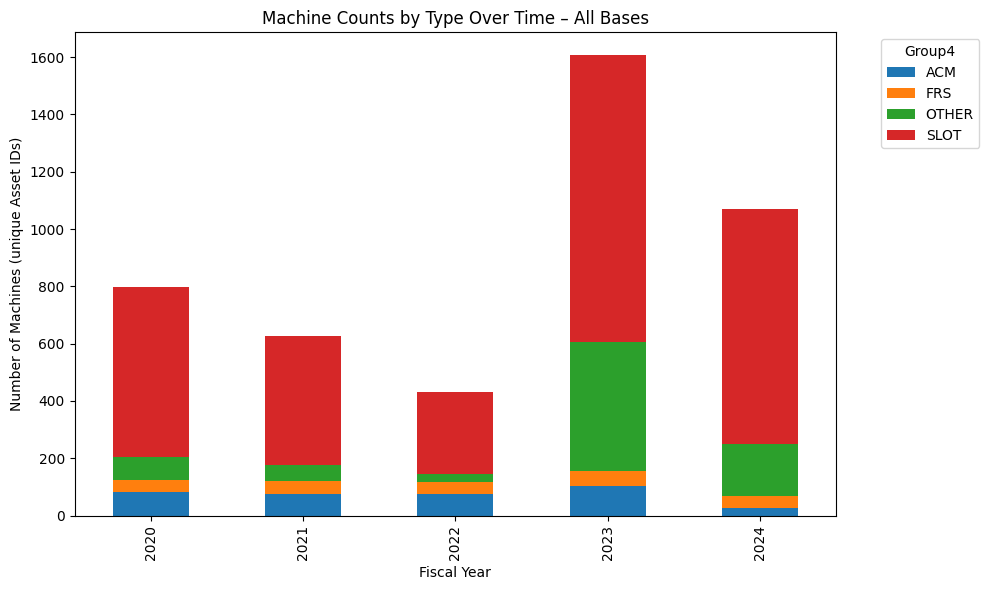

In [6]:
# Stacked bar: absolute counts by year
pivot_counts = g4_year.pivot(index='Year', columns='Group4', values='MachineCount').fillna(0)
pivot_counts = pivot_counts.sort_index()
ax = pivot_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Machine Counts by Type Over Time – All Bases')
plt.ylabel('Number of Machines (unique Asset IDs)')
plt.xlabel('Fiscal Year')
plt.legend(title='Group4', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


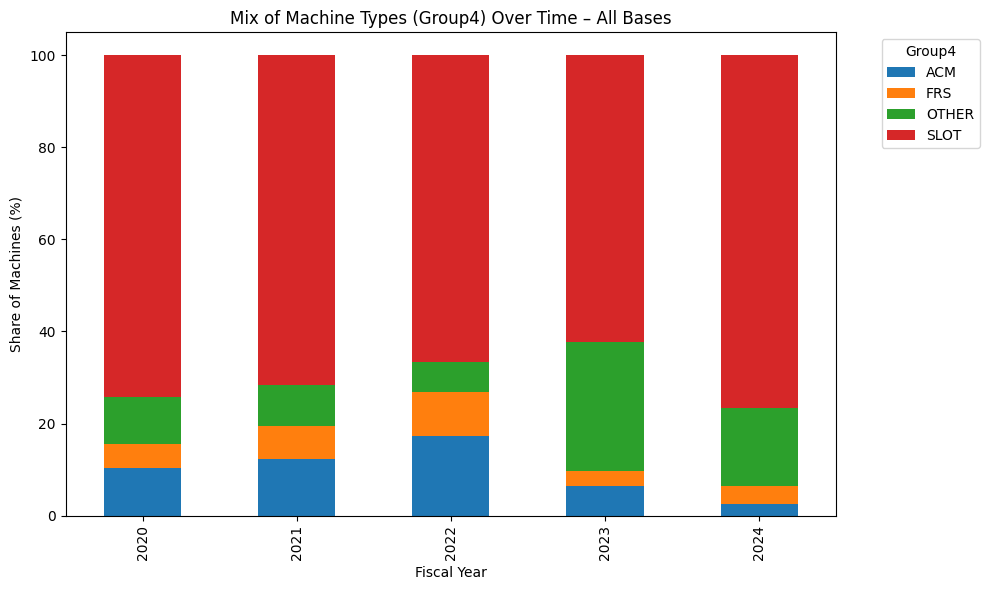

In [7]:
# Stacked bar: percentage mix by year
pivot_share = g4_year.pivot(index='Year', columns='Group4', values='Share').fillna(0)
pivot_share = pivot_share.sort_index()
ax = pivot_share.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Mix of Machine Types (Group4) Over Time – All Bases')
plt.ylabel('Share of Machines (%)')
plt.xlabel('Fiscal Year')
plt.legend(title='Group4', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [8]:
# --- Base-level trends: How machine type mix changes at major bases over time ---
# Identify top bases by total unique assets across all years
base_totals = (
    assets.groupby('Base')['Asset']
          .nunique()
          .sort_values(ascending=False)
)
top_bases = base_totals.head(8).index  # adjust N as needed
print('Top bases:', list(top_bases))

subset = assets[assets['Base'].isin(top_bases)].copy()

# Count machines per Base/Year/Group4
base_g4_year = (
    subset.groupby(['Base', 'Year', 'Group4'])['Asset']
          .nunique()
          .reset_index(name='MachineCount')
)

# Normalize to percentage within each Base+Year
base_g4_year['BaseYearTotal'] = (
    base_g4_year.groupby(['Base', 'Year'])['MachineCount'].transform('sum')
)
base_g4_year['Share'] = base_g4_year['MachineCount'] / base_g4_year['BaseYearTotal'] * 100
base_g4_year.head(12)


Top bases: ['OKINAWA', 'PYONGTAEK', 'KAISERSLAUTERN', 'ZAMA', 'DAEGU', 'SEOUL', 'VILSECK', 'YOKOSUKA']


,Base,Year,Group4,MachineCount,BaseYearTotal,Share
0,DAEGU,2020,ACM,10,60,16.666667
1,DAEGU,2020,FRS,3,60,5.000000
2,DAEGU,2020,OTHER,15,60,25.000000
3,DAEGU,2020,SLOT,32,60,53.333333
4,DAEGU,2021,ACM,8,49,16.326531
5,DAEGU,2021,FRS,4,49,8.163265
6,DAEGU,2021,OTHER,6,49,12.244898
7,DAEGU,2021,SLOT,31,49,63.265306
8,DAEGU,2022,ACM,6,47,12.765957
9,DAEGU,2022,FRS,2,47,4.255319


## Main Takeaway

The overall mix of machines at bases remains dominated by SLOT machines every year, but the composition underneath that dominance does shift, especially in 2023. From 2020–2022, the non-slot categories (ACM, FRS, ITC/OTHER) stay relatively steady and modest in size. Then 2023 produces a striking spike: both the total number of machines and the share attributed to ITC/OTHER jump sharply. By 2024, that spike relaxes—SLOT machines once again take up a very large majority of all equipment, but ITC/OTHER remains elevated compared to earlier years.

## Additional Analysis

--- Asset Stability Analysis ---
Total unique Asset IDs observed: 2771
Machines from 2020 still active in 2024: 84.17%


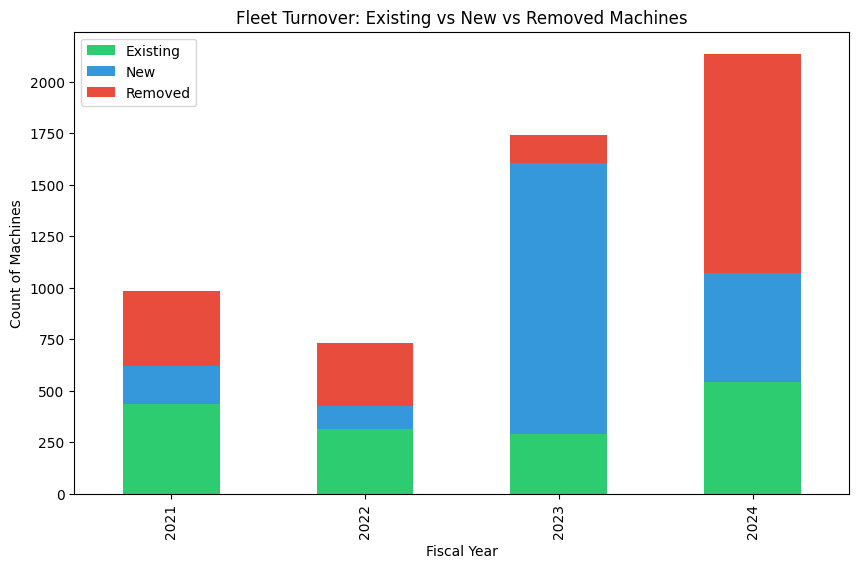

In [11]:
# Create a matrix of Asset Presence
# Index = Asset ID, Columns = Year, Values = 1 (Present) or 0 (Absent)
asset_matrix = pd.crosstab(assets["Asset"], assets["Year"])

# Calculate Retention
print("--- Asset Stability Analysis ---")
print(f"Total unique Asset IDs observed: {len(asset_matrix)}")

# How many assets existed in 2020 and were still there in 2024?
assets_2020 = asset_matrix[asset_matrix[2020] > 0].index
survivors = asset_matrix.loc[assets_2020, 2024]
retention_rate = (sum(survivors) / len(assets_2020)) * 100

print(f"Machines from 2020 still active in 2024: {retention_rate:.2f}%")

# Visualize New vs Returning Assets
# An asset is 'New' in year X if it wasn't seen in year X-1
asset_status = pd.DataFrame(index=YEARS[1:], columns=["Existing", "New", "Removed"])

for i in range(1, len(YEARS)):
    prev_yr = YEARS[i - 1]
    curr_yr = YEARS[i]
    
    prev_assets = set(assets[assets["Year"] == prev_yr]["Asset"])
    curr_assets = set(assets[assets["Year"] == curr_yr]["Asset"])
    
    existing = len(prev_assets.intersection(curr_assets))
    new_adds = len(curr_assets - prev_assets)
    removed = len(prev_assets - curr_assets)
    
    asset_status.loc[curr_yr] = [existing, new_adds, removed]

# Plot Turnover
ax = asset_status.astype(int).plot(
    kind="bar",
    stacked=True,
    color=["#2ecc71", "#3498db", "#e74c3c"],
    figsize=(10, 6),
)
plt.title("Fleet Turnover: Existing vs New vs Removed Machines")
plt.ylabel("Count of Machines")
plt.xlabel("Fiscal Year")
plt.show()


## How machine counts at major bases change over time

If base information is available, we can look at how the number of installed machines changes at the busiest bases across years.

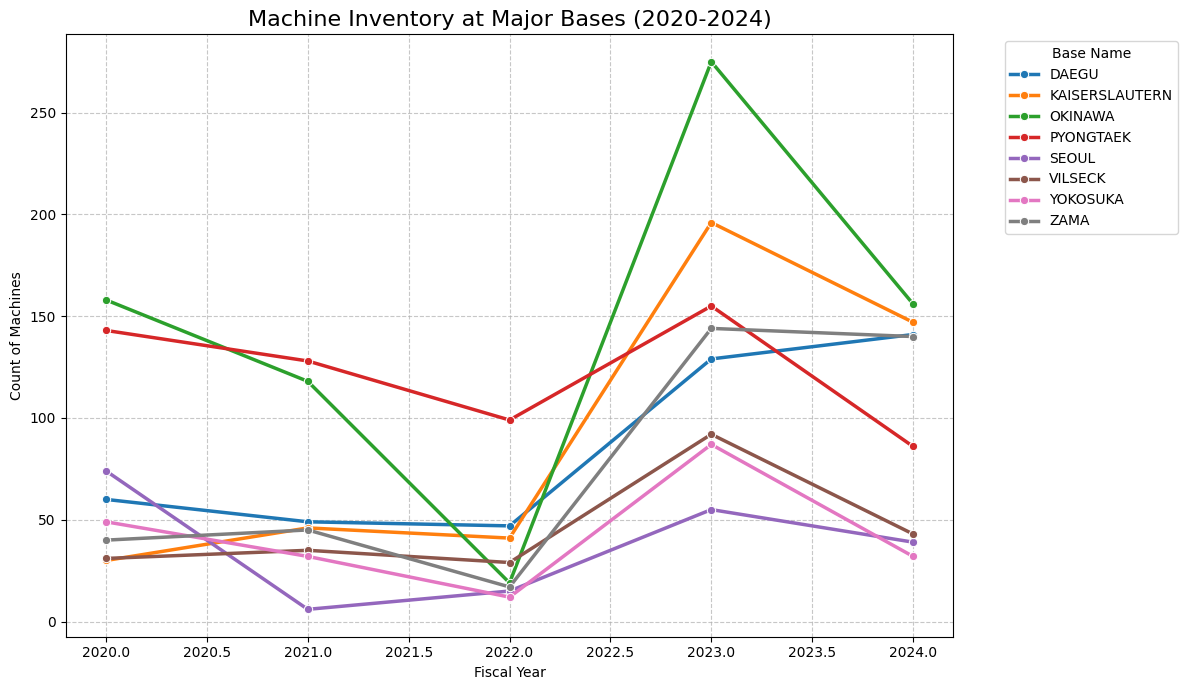

In [12]:
# 1. Count machines per Year and Base
base_counts = assets.groupby(['Year', 'Base'])['Asset'].nunique().reset_index()

# 2. Find Top 8 Bases by total volume
top_bases = base_counts.groupby('Base')['Asset'].sum().nlargest(8).index
filtered_bases = base_counts[base_counts['Base'].isin(top_bases)]

# 3. Pivot
base_pivot = filtered_bases.pivot(index='Year', columns='Base', values='Asset').fillna(0)

# 4. Plot
plt.figure(figsize=(12, 7))
sns.lineplot(data=filtered_bases, x='Year', y='Asset', hue='Base', marker='o', linewidth=2.5)

plt.title('Machine Inventory at Major Bases (2020-2024)', fontsize=16)
plt.ylabel('Count of Machines')
plt.xlabel('Fiscal Year')
plt.legend(title='Base Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Vendor / machine-type mix over time

Here we look at how the mix of machine **vendors/types** changes between years.
We:

1. Count machines by `Year` and `Vendor`.
2. Keep only the top vendors overall (to keep the chart legible).
3. Plot a stacked bar chart showing the distribution by year.

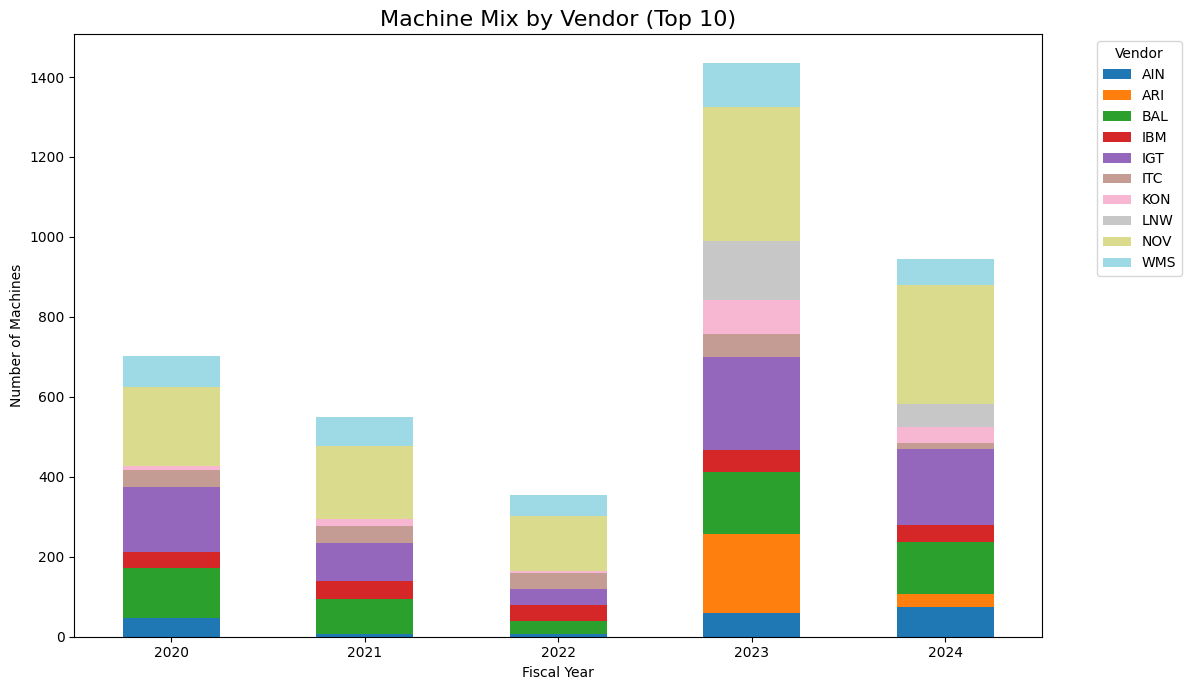

In [13]:
# 1. Count machines per Year and Vendor
vendor_counts = assets.groupby(['Year', 'Vendor'])['Asset'].nunique().reset_index()

# 2. Find the Top 10 Vendors (to keep the chart readable)
top_vendors = vendor_counts.groupby('Vendor')['Asset'].sum().nlargest(10).index
filtered_vendors = vendor_counts[vendor_counts['Vendor'].isin(top_vendors)]

# 3. Pivot the data for plotting
vendor_pivot = filtered_vendors.pivot(index='Year', columns='Vendor', values='Asset').fillna(0)

# 4. Plot Stacked Bar Chart
ax = vendor_pivot.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='tab20')

ax.set_title('Machine Mix by Vendor (Top 10)', fontsize=16)
ax.set_ylabel('Number of Machines')
ax.set_xlabel('Fiscal Year')
plt.xticks(rotation=0)
plt.legend(title='Vendor', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()